<a href="https://colab.research.google.com/github/Oleksij-gh/PersonaFilmRecommender/blob/main/RecSysBinary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://grouplens.org/datasets/movielens/tag-genome-2021/

Global parameters

In [2]:
seed = 42

to do:

Значения характера - категориальные признаки и прогнать через OHE

# Data

## Donload and Unzip

In [3]:
import zipfile

In [4]:
!gdown 1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF

Downloading...
From: https://drive.google.com/uc?id=1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF
To: /content/RecSys.zip
100% 9.92M/9.92M [00:00<00:00, 56.1MB/s]


In [5]:
with zipfile.ZipFile('/content/RecSys.zip') as zip:
    zip.extractall('/content/data')

In [6]:
!wget https://files.grouplens.org/datasets/tag-genome-2021/genome_2021.zip

--2024-05-28 09:12:23--  https://files.grouplens.org/datasets/tag-genome-2021/genome_2021.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928028583 (1.8G) [application/zip]
Saving to: ‘genome_2021.zip’

genome_2021.zip     100%[===================>]   1.79G  75.1MB/s    in 30s     

2024-05-28 09:12:53 (61.5 MB/s) - ‘genome_2021.zip’ saved [1928028583/1928028583]



In [7]:
with zipfile.ZipFile('/content/genome_2021.zip') as zip:
    zip.extractall('/content/data')

## Preprocessing

In [8]:
import pandas as pd

### Personality

In [9]:
person_data = pd.read_csv('/content/data/2018-personality-data.csv')
rating_data = pd.read_csv('/content/data/2018_ratings.csv')

In [10]:
person_data = person_data.drop([' assigned metric',
       ' assigned condition', ' movie_1', ' predicted_rating_1', ' movie_2',
       ' predicted_rating_2', ' movie_3', ' predicted_rating_3', ' movie_4',
       ' predicted_rating_4', ' movie_5', ' predicted_rating_5', ' movie_6',
       ' predicted_rating_6', ' movie_7', ' predicted_rating_7', ' movie_8',
       ' predicted_rating_8', ' movie_9', ' predicted_rating_9', ' movie_10',
       ' predicted_rating_10', ' movie_11', ' predicted_rating_11',
       ' movie_12', ' predicted_rating_12', ' is_personalized',
       ' enjoy_watching '], axis=1)

In [11]:
person_data.rename({' openness': 'openness',
                    ' agreeableness': 'agreeableness',
                    ' emotional_stability': 'emotional_stability',
                    ' conscientiousness': 'conscientiousness',
                    ' extraversion': 'extraversion',
                    }, inplace=True, axis=1)

In [12]:
rating_data.rename({'useri': 'userid',
                    ' rating': 'rating',
                    ' movie_id': 'movie_id'}, inplace=True, axis=1)

In [13]:
df_personality = person_data.merge(rating_data, how="inner", on=['userid'])

In [14]:
df_personality = df_personality.drop([' tstamp '], axis=1)

In [15]:
df_personality['rating'].astype('int').value_counts()

rating
3    416879
4    348024
2    158296
5     72821
1     52546
0     21637
Name: count, dtype: int64

<Axes: >

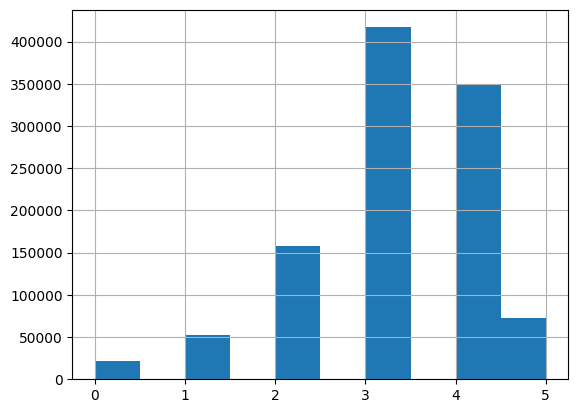

In [16]:
df_personality['rating'].astype('int').hist()

### Movies

In [17]:
import json

In [18]:
def GetJsonDf(path):
  json_list = [json.loads(line) for line in open(path, 'r')]
  json_str = json.dumps(json_list)
  df = pd.read_json(json_str)
  return df

Metadata

In [19]:
df_metadata = GetJsonDf('/content/data/movie_dataset_public_final/raw/metadata.json')

In [20]:
df_metadata.rename({'item_id': 'movie_id'}, inplace=True, axis=1)

Tags

In [21]:
df_survey = GetJsonDf('/content/data/movie_dataset_public_final/raw/survey_answers.json')

In [22]:
df_survey.rename({'item_id': 'movie_id'}, inplace=True, axis=1)

In [23]:
df_tags = GetJsonDf('/content/data/movie_dataset_public_final/raw/tags.json')

In [24]:
df_tags.rename({'id': 'tag_id'}, inplace=True, axis=1)

In [25]:
res = (df_survey.groupby(['movie_id'], as_index=False).apply(lambda x: x.nlargest(3,['score'])).reset_index(level=0, drop=True))

In [26]:
res = res.merge(df_tags, how="left", on=['tag_id'])

In [27]:
tags = {}
for i, row in res.iterrows():
  try:
    tags[row['movie_id']].append(row['tag'])
  except:
    tags[row['movie_id']] = [row['tag']]



In [28]:
tag_count_df = GetJsonDf('/content/data/movie_dataset_public_final/raw/tag_count.json')

In [29]:
#reviews_df = GetJsonDf('/content/data/movie_dataset_public_final/raw/reviews.json') # вышибает по памяти

### Merge

In [84]:
df_merge = df_personality.merge(df_metadata, how="left", on=['movie_id'])

In [85]:
def GetTag(movie_id, num, tags):
  try:
    return tags[movie_id][num-1]
  except:
    return None

In [86]:
for i in range(3):
  df_merge['tag'+str(i+1)] = df_merge['movie_id'].apply(lambda x: GetTag(x, i, tags))

In [87]:
df_to_save = df_merge.drop(['dateAdded', 'avgRating', 'imdbId',], axis=1)

In [88]:
df_merge.drop(['dateAdded', 'avgRating', 'imdbId', 'movie_id'], inplace=True, axis=1)

In [89]:
df_merge.drop(['directedBy', 'starring'], inplace=True, axis=1)

In [96]:
df_merge.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,rating,title,tag1,tag2,tag3
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,5.0,Toy Story (1995),animation,pixar,comedy
1,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,4.0,Jumanji (1995),animation,animals,animals
2,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,4.0,Grumpier Old Men (1995),minnesota,sequel,minnesota
3,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,5.0,Father of the Bride Part II (1995),pregnancy,good sequel,comedy
4,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,4.0,Heat (1995),action,crime,dialogue


# Encoding

In [97]:
df = df_merge.copy()

In [98]:
df['rating'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

In [99]:
categorical_columns = ['openness', 'agreeableness', 'emotional_stability', 'conscientiousness', 'extraversion']
for column in categorical_columns:
  df[column] = df[column].astype(object)

In [100]:
df.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,rating,title,tag1,tag2,tag3
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Toy Story (1995),animation,pixar,comedy
1,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Jumanji (1995),animation,animals,animals
2,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Grumpier Old Men (1995),minnesota,sequel,minnesota
3,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Father of the Bride Part II (1995),pregnancy,good sequel,comedy
4,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Heat (1995),action,crime,dialogue


In [39]:
from sklearn.preprocessing import OneHotEncoder

In [40]:
X = df.drop('rating', axis = 1)#.values.astype('float32')
y = df['rating'].values.astype('int')

In [41]:
!pip install category_encoders --quiet
import category_encoders as ce

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [42]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()
cbe_encoder.fit(X, y)
X_cbe = cbe_encoder.transform(X)

In [43]:
X = X_cbe.values.astype('float32')

UnderSampling

# NN

## Pytorch

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import copy
import numpy as np

In [46]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Define dataloaders

In [55]:
from torch.utils.data import DataLoader, TensorDataset, random_split

In [60]:
# Преобразование в тензоры
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # для бинарной классификации выход должен быть размерности (N, 1)

# Создание датасета и разделение на обучающую, тестовую и валидационную выборки
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define model

In [61]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.normalize = nn.BatchNorm1d(input_dim)
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.normalize(x)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [63]:
# training parameters
n_epochs = 20
learning_rate = 1e-3

model = Model(X_train.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

total_params = sum(p.numel() for p in model.parameters())
params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable params count: {params_trainable }')
print(f'Total params count: {total_params}')

Trainable params count: 3349
Total params count: 3349


### Train and evaluate

In [64]:
# Обучение
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

    for inputs, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        progress_bar.set_postfix(train_loss=loss.item())

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Оценка на валидационной выборке
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')


Epoch 1/20, Train Loss: 0.5149, Val Loss: 0.5047


Epoch 2/20, Train Loss: 0.5133, Val Loss: 0.5050


Epoch 3/20, Train Loss: 0.5126, Val Loss: 0.5061


Epoch 4/20, Train Loss: 0.5125, Val Loss: 0.5059


Epoch 5/20, Train Loss: 0.5121, Val Loss: 0.5036


Epoch 6/20, Train Loss: 0.5120, Val Loss: 0.5040


Epoch 7/20, Train Loss: 0.5121, Val Loss: 0.5032


Epoch 8/20, Train Loss: 0.5118, Val Loss: 0.5028


Epoch 9/20, Train Loss: 0.5119, Val Loss: 0.5031


Epoch 10/20, Train Loss: 0.5117, Val Loss: 0.5064


Epoch 11/20, Train Loss: 0.5115, Val Loss: 0.5038


Epoch 12/20, Train Loss: 0.5114, Val Loss: 0.5043


Epoch 13/20, Train Loss: 0.5114, Val Loss: 0.5037


Epoch 14/20, Train Loss: 0.5115, Val Loss: 0.5037


Epoch 15/20, Train Loss: 0.5114, Val Loss: 0.5034


Epoch 16/20, Train Loss: 0.5111, Val Loss: 0.5024


Epoch 17/20, Train Loss: 0.5110, Val Loss: 0.5026


Epoch 18/20, Train Loss: 0.5110, Val Loss: 0.5035


Epoch 19/20, Train Loss: 0.5111, Val Loss: 0.5022


Epoch 20/20, Train Loss: 0.5112, Val Loss: 0.5034


Loss

In [65]:
import matplotlib.pyplot as plt

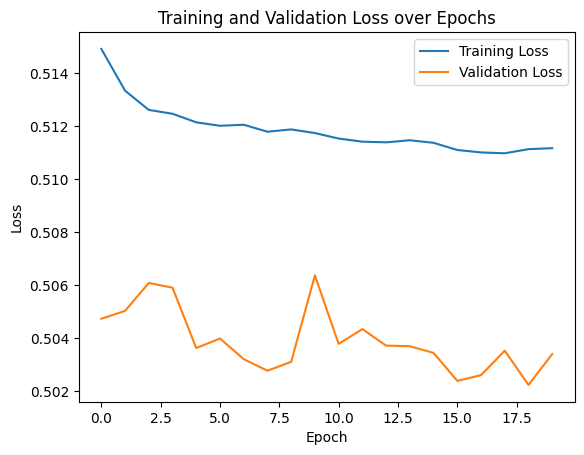

In [66]:
# Построение графиков ошибки обучения и валидации
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

Evaluate

In [67]:
# Тестирование
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {correct / total * 100:.2f}%')

Accuracy: 74.50%


In [74]:
y_pred = predicted.numpy()
y_test = labels.numpy()

# Test model

## Predict

## Calculate metrics

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [76]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy = {accuracy:.3f}')
print(f'Precision = {precision:.3f}')
print(f'Recall = {recall:.3f}')
print(f'F1 = {f1:.3f}')

Accuracy = 0.737
Precision = 0.800
Recall = 0.727
F1 = 0.762


Save model

In [81]:
torch.save(model.state_dict(), '/content/drive/MyDrive/rec_sys/model/model_weights.pth')

In [82]:
import pickle

In [83]:
with open('/content/drive/MyDrive/rec_sys/cbencoder/catboost_encoder.pkl', 'wb') as f:
    pickle.dump(cbe_encoder, f)

При обучении нейросети была использована функция ошибки: **BinaryCrossEntropy**

Для оценки работы модели на тестовой выборки используются следующие метрики:

1. **F1-score**
$$F_{1}=\frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
2. **Accuracy**
$$\text{Precision} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$
3. **Precision**
$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$
4. **Recall**
$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

Для оценки работы сервиса после запуска в прод будут использованы следующие метрики:

1. **P@K** (Precision at K)
$$\text{Precision at K} = \frac{\text{Number of relevant items in K}}{\text{Total number of items in K}}$$
2. **R@K** (Recall at K)
$$\text{Recall at K} = \frac{\text{Number of relevant items in K}}{\text{Total number of relevant items}}$$

In [129]:
df_films = df_to_save[['movie_id','title', 'directedBy', 'starring', 'tag1', 'tag2', 'tag3']]

In [132]:
df_films.to_csv('/content/drive/MyDrive/rec_sys/data/films.csv')

In [125]:
df_personality.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5
6419,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0
7248,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5
8162,92561f21446e017dd6b68b94b23ad5b7,5.5,5.5,4.0,4.5,4.0
11063,030001ac2145a938b07e686a35a2d638,5.5,5.5,3.5,4.5,2.5


In [130]:
df_films.head()

,movie_id,title,directedBy,starring,tag1,tag2,tag3
0,1,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",animation,pixar,comedy
1,2,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",animation,animals,animals
2,3,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",minnesota,sequel,minnesota
3,5,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",pregnancy,good sequel,comedy
4,6,Heat (1995),Michael Mann,"Robert De Niro, Al Pacino, Val Kilmer, Jon Voi...",action,crime,dialogue


In [127]:
df.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,rating,title,tag1,tag2,tag3
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Toy Story (1995),animation,pixar,comedy
1,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Jumanji (1995),animation,animals,animals
2,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Grumpier Old Men (1995),minnesota,sequel,minnesota
3,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Father of the Bride Part II (1995),pregnancy,good sequel,comedy
4,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5,1,Heat (1995),action,crime,dialogue


In [ ]:
!pip install category_encoders

In [245]:
import category_encoders as ce
import pickle
import pandas as pd
import torch
import json

MODEL_PATH = '/content/drive/MyDrive/rec_sys/model/model_weights.pth'
CBE_PATH = '/content/drive/MyDrive/rec_sys/cbencoder/catboost_encoder.pkl'
INPUT_PATH = '/content/sample2.json'

with open(CBE_PATH, 'rb') as f:
    encoder = pickle.load(f)


df = pd.read_json(INPUT_PATH, orient='index')
X = encoder.transform(df).values
X = torch.tensor(X, dtype=torch.float32)

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.normalize = nn.BatchNorm1d(input_dim)
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.normalize(x)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

model = Model(X.shape[1])
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
with torch.no_grad():
  predict = model(X)
predict = (predict > 0.5).float()

df['label'] = predict.numpy()
output = {
    'title': str(df['title'][0]),
    'label': float(predict.numpy()[0][0])
}

df[['userid', 'title', 'label']].to_json('output.json', orient='index')

In [247]:
df

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,title,tag1,tag2,tag3,label
0,8e7cebf9a234c064b75016249f2ac65e,5,2,3,2.5,6.5,Toy Story (1995),animation,pixar,comedy,1.0
1,8e7cebf9a234c064b75016249f2ac65e,5,2,3,2.5,6.5,Heat (1995),action,crime,dialogue,1.0
